In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
import pyro.distributions as dist
import pyro.poutine as poutine

from src.modules.config import read_config
from src.modules.datageneration import load_data, data_functions

from src import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import src.tyxe as tyxe

import seaborn as sns

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "./configs/underspecified"
PROFILE = "model-fixed"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [5]:
# make plots dir
if not os.path.exists(BASE_DIR + "/plots"):
    os.makedirs(BASE_DIR + "/plots")


sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

====== Generating profile non-linear-1d-1k ======
Train: (-2, 2)
Y-space: -5.294485024092987 - 2.300653219852837
In Domain: (-2, 2)
Y-space: -5.25529371373356 - 2.313922379586602
Out Domain: (-4, 4)
Y-space: -11.463573344266871 - 8.271277740579123


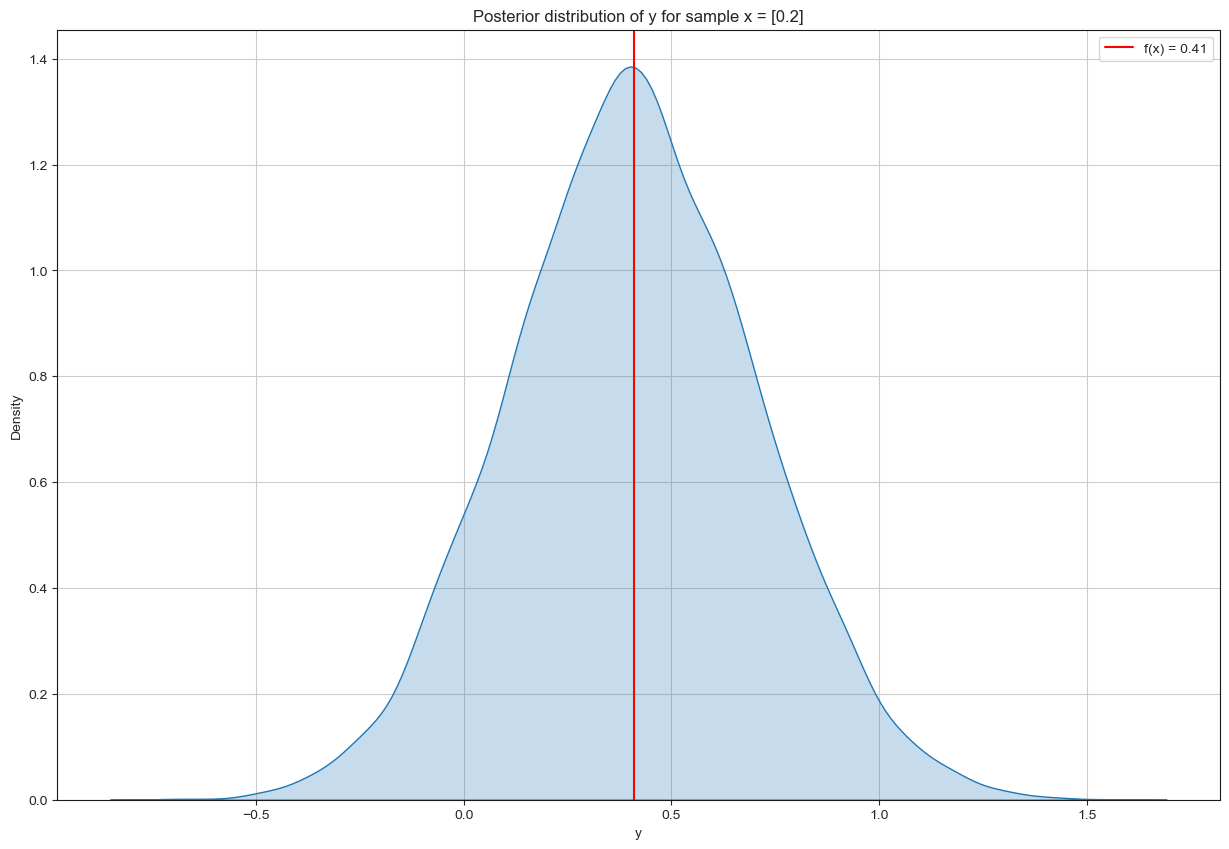

In [6]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [7]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([400, 1]) torch.Size([400, 1])


In [8]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([400, 1]) torch.Size([400, 1])


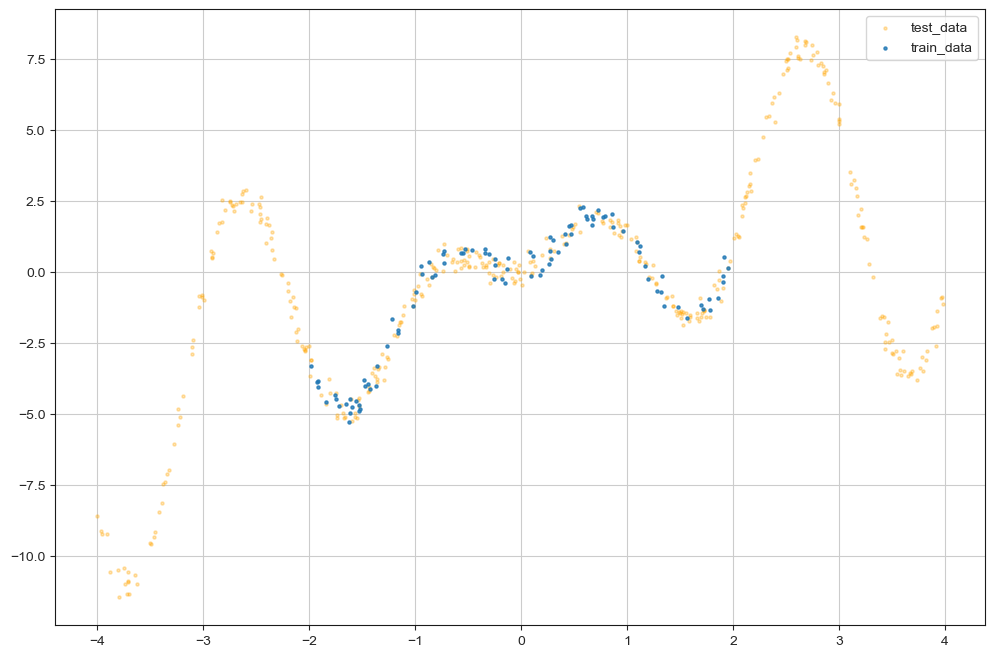

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=5, alpha=0.3, label="test_data")
plt.scatter(x_train.squeeze(), y_train, s=5, alpha=0.8, label="train_data")
plt.legend()


In [10]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=512)

In [11]:
"""SVI"""

'SVI'

In [12]:
#net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.3))
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [13]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 10000, callback=callback, num_particles=5)

epoch: 0 | elbo: 1870.4603759765628
epoch: 1000 | elbo: 1462.169775390625
epoch: 2000 | elbo: 1147.0303955078125
epoch: 3000 | elbo: 932.6083129882813
epoch: 4000 | elbo: 760.4506958007812
epoch: 5000 | elbo: 632.8310546875
epoch: 6000 | elbo: 526.7891174316406
epoch: 7000 | elbo: 446.88486328125
epoch: 8000 | elbo: 385.9125244140625
epoch: 9000 | elbo: 335.4004211425781


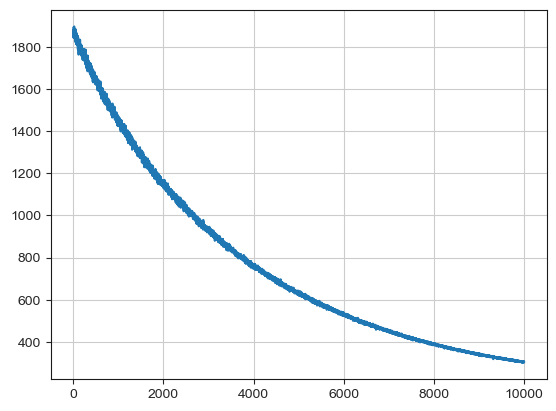

In [14]:
plt.plot(elbos)

In [15]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

In [16]:
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

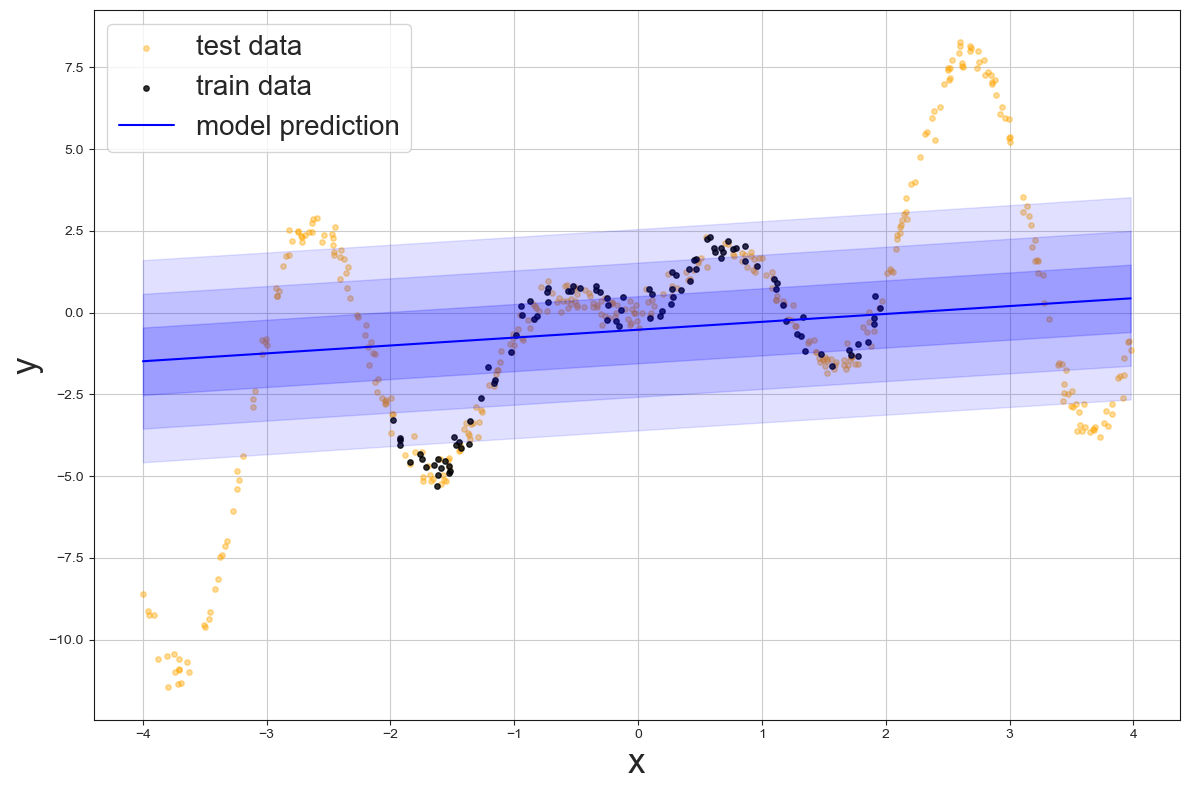

In [17]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="train data")
plt.plot(x_test[test_sort], means, color="blue", label="model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")

plt.legend( fontsize=20)
ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/sl.svg", format="svg", dpi=1200)
#plt.savefig(f"{BASE_DIR}/plots/sf.svg", format="svg")
plt.show()

In [18]:
#net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.3))
#likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [19]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 10000, callback=callback, num_particles=5)

epoch: 0 | elbo: 2546.6864257812504
epoch: 1000 | elbo: 2351.987255859375
epoch: 2000 | elbo: 2186.6499999999996
epoch: 3000 | elbo: 2052.460595703125
epoch: 4000 | elbo: 1937.2054931640623
epoch: 5000 | elbo: 1836.6089111328126
epoch: 6000 | elbo: 1754.1376953125
epoch: 7000 | elbo: 1686.2683593749998
epoch: 8000 | elbo: 1617.3106689453125
epoch: 9000 | elbo: 1571.918603515625


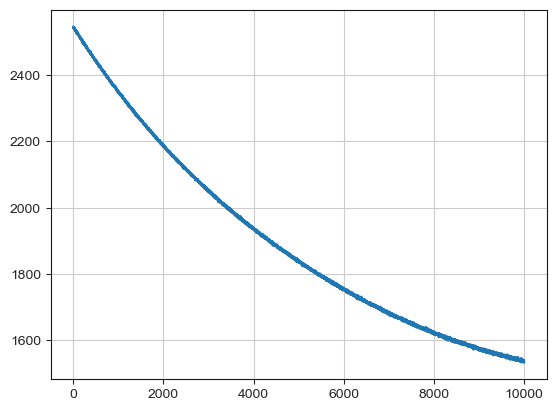

In [20]:
plt.plot(elbos)

In [21]:
test_sort = torch.argsort(x_test.squeeze())
preds2 = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

In [22]:
means, stds = preds2
means, stds = means.detach().cpu(), stds.detach().cpu()

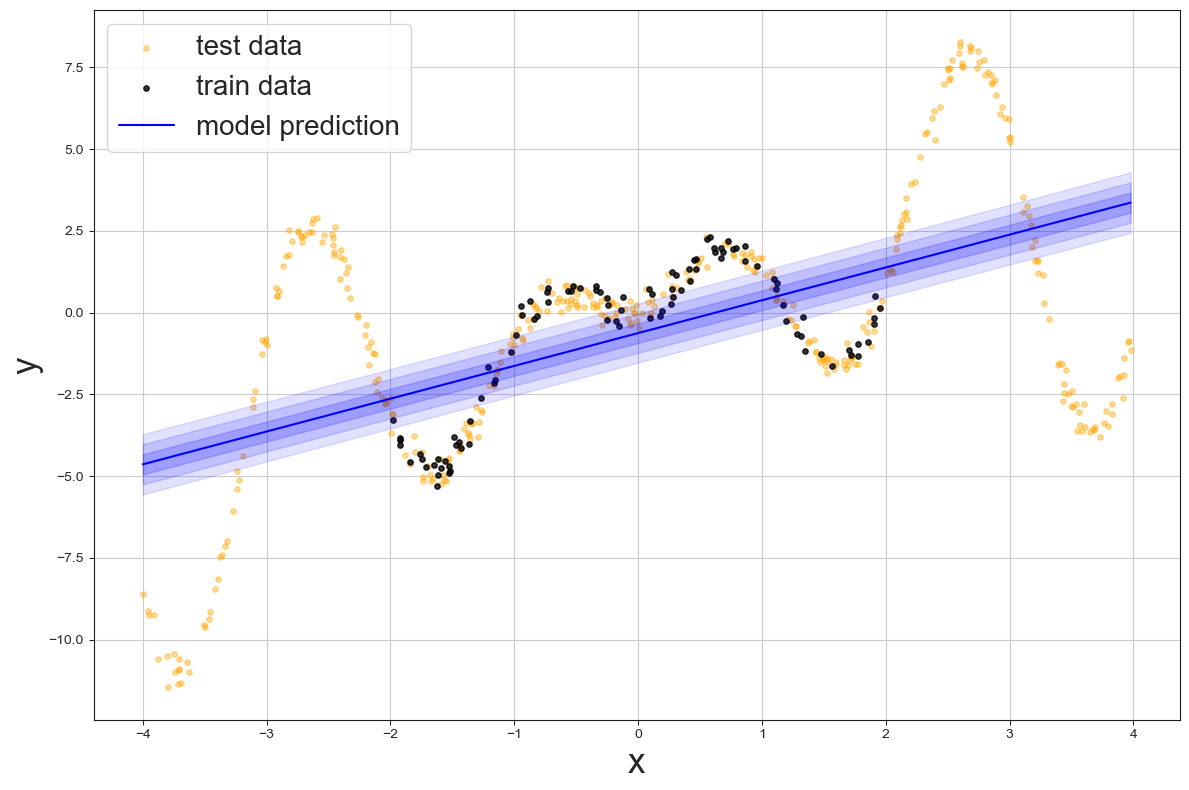

In [25]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="train data")
plt.plot(x_test[test_sort], means, color="blue", label="model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")

plt.legend( fontsize=20)
ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
#plt.savefig(f"{BASE_DIR}/plots/sl.svg", format="svg")
plt.savefig(f"{BASE_DIR}/plots/sf.svg", format="svg", dpi=1200)
plt.show()

In [24]:
raise Exception("stop here")

Exception: stop here

In [ ]:
#raise Exception("stop")

In [ ]:
"""MCMC"""

'MCMC'

In [ ]:
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [ ]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=200)

Sample: 100%|██████████| 1200/1200 [00:04, 276.90it/s, step size=6.60e-01, acc. prob=0.932]


In [ ]:
bnn._mcmc.diagnostics()

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/pyro/infer/mcmc/util.py:498: UserWarning: Traceback (most recent call last):
  File "/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/pyro/infer/mcmc/util.py", line 496, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/pyro/ops/stats.py", line 189, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/pyro/ops/stats.py", line 137, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/pyro/ops/stats.py", line 97, in autocorrelation
    raise NotImplementedError(
NotImplementedError: For CPU tensor, this method is only supported with MKL installed.

  warnings.warn(tb.format_exc())


{'likelihood._scale': OrderedDict([('n_eff', tensor(nan)),
              ('r_hat', tensor(0.9998))]),
 'net.bias': OrderedDict([('n_eff', tensor([nan])),
              ('r_hat', tensor([0.9990]))]),
 'net.weight': OrderedDict([('n_eff', tensor([[nan]])),
              ('r_hat', tensor([[1.0003]]))]),
 'divergences': {'chain 0': []},
 'acceptance rate': {'chain 0': 0.996}}

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds3 = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

In [ ]:
means, stds = preds3
means, stds = means.detach().cpu(), stds.detach().cpu()

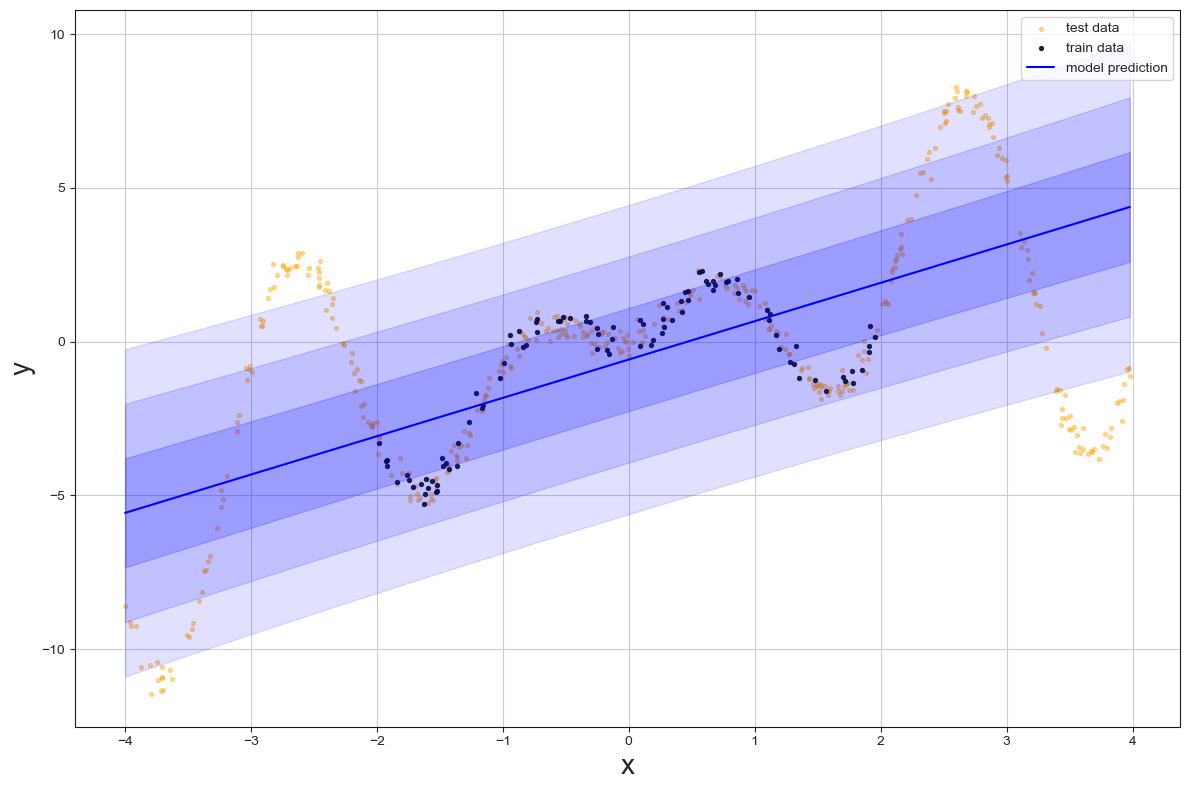

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="train data")
plt.plot(x_test[test_sort], means, color="blue", label="model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")

plt.legend(fontsize=20)
ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/sl-mcmc.svg", format="svg", dpi=1200)
plt.show()

In [ ]:
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.3))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [ ]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=200)

Sample: 100%|██████████| 1200/1200 [00:01, 606.81it/s, step size=1.06e+00, acc. prob=0.872]


In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds4 = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

In [ ]:
means, stds = preds4
means, stds = means.detach().cpu(), stds.detach().cpu()

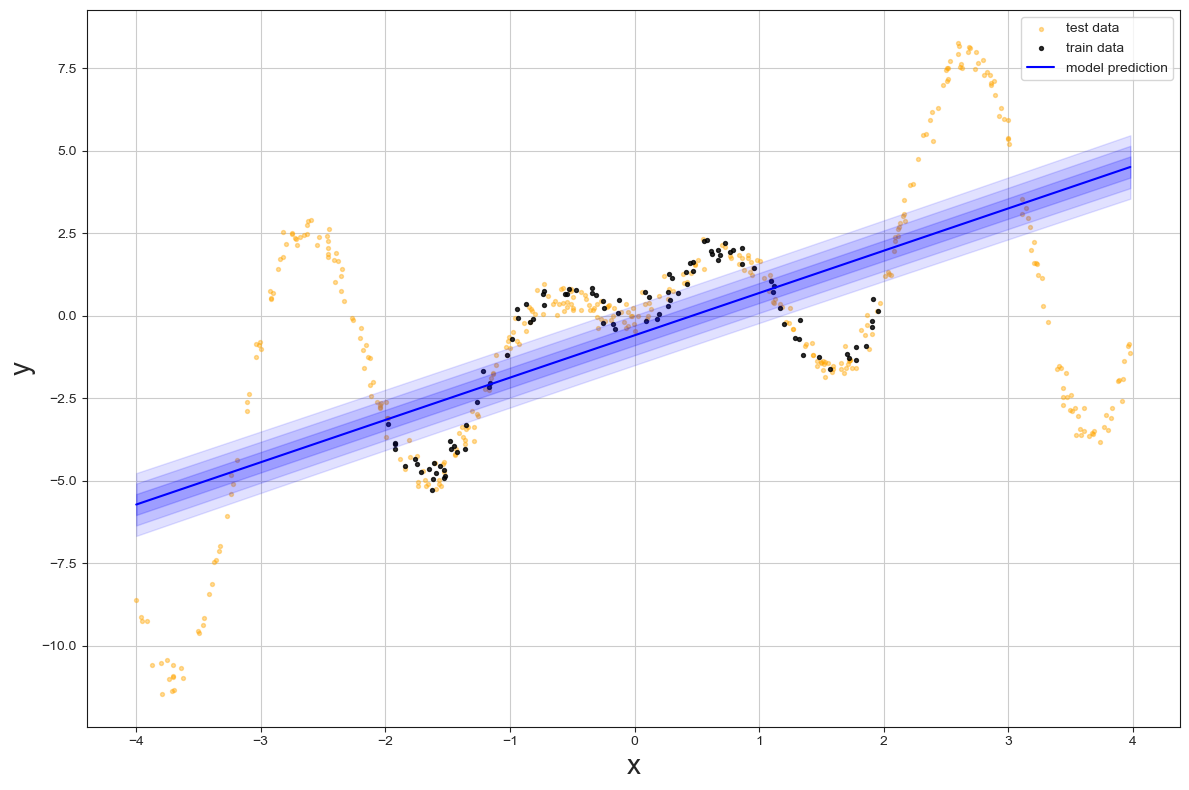

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=8, alpha=0.4, label="test data")
plt.scatter(x_train, y_train, color="black", s=8, alpha=0.8, label="train data")
plt.plot(x_test[test_sort], means, color="blue", label="model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.0/(0.4 + (0.15*c))) * 0.1, color="blue")

plt.legend()
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/sf-mcmc.svg", format="svg", dpi=1200)
plt.show()